# MODIS Water Ensemble Learning
Version: 0.1.0

Date modified: 02.08.2022

Modifier: Caleb Spradlin

In [1]:
import csv
import datetime
import glob
import joblib
import numpy as np
import os
import pandas as pd
from pathlib import Path
import sys

import xgboost as xgb

from sklearn.ensemble import RandomForestClassifier as skRF
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.inspection import permutation_importance

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

#GDAL Stuff
from osgeo import gdalconst
from osgeo import gdal

from pprint import pprint

sys.path.append('../scripts/')
import notebook_util as nu

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
FIGURE_OUTPUT_DIR = '/att/nobackup/cssprad1/projects/modis_water/code/modis_water_random_forest/view/notebook/output'
RASTER_OUTPUT_DIR = '/att/nobackup/cssprad1/projects/modis_water/code/modis_water_random_forest/view/notebook/output'
MODEL_OUTPUT_DIR = '/att/nobackup/cssprad1/projects/modis_water/models/'

GPU = True
TILE = 'global'
MODEL = 'ensemble'
TEST_RATIO = 0.2
RANDOM_STATE = 42
LABEL_NAME = 'water'
DATA_TYPE = np.int16
colsToDrop = ['x_offset', 'y_offset']
v_names = ['sur_refl_b01_1','sur_refl_b02_1','sur_refl_b03_1',
           'sur_refl_b04_1','sur_refl_b05_1','sur_refl_b06_1',
           'sur_refl_b07_1','ndvi','ndwi1','ndwi2']

In [3]:
if GPU:
    nu.setup_one_gpu() # Choose the GPU with the lowest memory usage

Picking GPU 0


In [4]:
def load_data(fpath, colsToDrop, yCol='water', testSize=0.2, randomState=42, 
              dataType=np.float32, cpu=True, splitXY=False, trainTestSplit=False,
             applyLog=False, imbalance=False, frac=0.1, land=False, multi=False, 
              multisample=1000000):
    """
    Simple helper function for loading data to be used by models
    :param fpath: Path to the data to be ingested.
    :param dataType: Data type to convert ingested data to.
    :param colsToDrop: Columns which are not necessary, from which to drop.
    :param testSize: Ration to
    """
    if multi:
        all_dfs = [pd.read_csv(path_) for path_ in fpath]
        df = pd.concat(all_dfs).sample(n=multisample, random_state=randomState)
        print('DF length: {}'.format(len(df.index)))
    else:   
        df = pd.read_parquet(fpath) if '.parquet' in fpath else pd.read_csv(fpath)
    df = df[df['sur_refl_b01_1'] + df['sur_refl_b02_1'] != 0]
    df = df[df['sur_refl_b07_1'] + df['sur_refl_b02_1'] != 0]
    df = df[df['sur_refl_b06_1'] + df['sur_refl_b02_1'] != 0]
    df = df.drop(columns=colsToDrop)
    cleanedDF = df[~df.isin([np.NaN, np.inf, -np.inf]).any(1)].dropna(axis=0).astype(dataType)
    if applyLog:
        for col in cleanedDF.drop([yCol], axis=1).columns:
            print('Applying log1p func to {}'.format(col))
            cleanedDF[col] = np.log1p(cleanedDF[col])
        cleanedDF = cleanedDF[~cleanedDF.isin([np.NaN, np.inf, -np.inf]).any(1)].dropna(axis=0)
    df = None
    if imbalance:
        groupedDF = cleanedDF.groupby('water')
        dfs = [groupedDF.get_group(y) for y in groupedDF.groups]
        sampledDF = dfs[1].sample(frac=frac)if land else dfs[0].sample(frac=frac)
        concatDF = sampledDF.append(dfs[0]) if land else sampledDF.append(dfs[1])
        concatDF = concatDF.sample(frac=1)
        concatDF = concatDF.reset_index()
        cleanedDF = concatDF.drop(columns=['index'])
    if not splitXY:
        return cleanedDF
    X = cleanedDF.drop([yCol], axis=1).astype(dataType)
    y = cleanedDF[yCol].astype(dataType)
    if trainTestSplit:
        return train_test_split(X, y, test_size=TEST_RATIO)
    else:
        return X, y

## Data 
- Read in to cuDF Dataframe
- Drop unnecessary columns
- Split into Xs and Ys

In [5]:
glob_string = '/att/nobackup/cssprad1/projects/modis_water/data/training_data/v1.1.0/MOD09_{}_*.parquet.gzip'.format(TILE)
data_paths = [fv for fv in glob.glob(glob_string)]
data_path = data_paths[0]
pprint(data_paths)

['/att/nobackup/cssprad1/projects/modis_water/data/training_data/v1.1.0/MOD09_global_WATER_TR_DATA_#5516128.parquet.gzip']


In [6]:
X_train, X_test, y_train, y_test = load_data(fpath=data_path,
                                             colsToDrop=colsToDrop,
                                             dataType=DATA_TYPE,
                                             cpu=True,
                                             splitXY=True,
                                             imbalance=False,
                                             trainTestSplit=True,
                                             multi=False)

kf = KFold(n_splits=5)
kf.get_n_splits(X_train)

5

In [7]:
_ = [print(column) for column in X_train.columns]

sur_refl_b01_1
sur_refl_b02_1
sur_refl_b03_1
sur_refl_b04_1
sur_refl_b05_1
sur_refl_b06_1
sur_refl_b07_1
ndvi
ndwi1
ndwi2


In [8]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
sur_refl_b01_1,4380548.0,458.511110,612.970780,-100.0,34.0,314.0,638.0,16000.0
sur_refl_b02_1,4380548.0,1461.142986,1458.133455,-100.0,2.0,1264.0,2651.0,16000.0
sur_refl_b03_1,4380548.0,312.911869,435.383649,-100.0,141.0,228.0,366.0,15361.0
sur_refl_b04_1,4380548.0,488.835178,518.920235,-100.0,140.0,432.0,661.0,16000.0
sur_refl_b05_1,4380548.0,1588.769992,1532.115449,-100.0,22.0,1401.0,2987.0,16000.0
sur_refl_b06_1,4380548.0,1202.776729,1150.814332,-100.0,94.0,1044.0,2091.0,16000.0
sur_refl_b07_1,4380548.0,661.244523,780.390797,-100.0,50.0,429.0,985.0,14952.0
ndvi,4380548.0,551.929821,8221.567752,-32762.0,-5296.0,2674.0,6711.0,32762.0
ndwi1,4380548.0,-2719.323276,6746.883503,-32759.0,-9166.0,-537.0,2039.0,32767.0
ndwi2,4380548.0,-132.785238,8622.007141,-32759.0,-7352.0,2372.0,5865.0,32767.0


In [9]:
def output_interesting_idx(df, column, threshold, greaterThan=True):
    dfToReturn = df[df[column] > threshold] if \
        greaterThan else df[df[column] < threshold]
    return dfToReturn

In [10]:
output_interesting_idx(X_train, 'ndvi', 10000)

,sur_refl_b01_1,sur_refl_b02_1,sur_refl_b03_1,sur_refl_b04_1,sur_refl_b05_1,sur_refl_b06_1,sur_refl_b07_1,ndvi,ndwi1,ndwi2
1300861,-74,42,-100,-100,63,69,85,29286,-2432,-3385
2283885,-7,28,139,122,36,225,201,16666,-7786,-7554
1536769,-100,422,-100,-100,1521,2108,1841,16211,-6664,-6270
996495,-2,11,58,29,22,37,36,14444,-5416,-5319
2517630,-1,4,-59,25,-85,258,60,16666,-9694,-8750
...,...,...,...,...,...,...,...,...,...,...
4227691,28,-17,215,151,-26,95,39,24627,-14358,-25454
5269310,-1,8,41,55,11,82,40,12857,-8222,-6666
2973938,-1,82,148,121,236,905,769,10246,-8338,-8072
2861208,24,-15,236,159,14,78,62,22203,-14761,-16382


In [11]:
output_interesting_idx(X_train, 'ndwi1', 10000)

,sur_refl_b01_1,sur_refl_b02_1,sur_refl_b03_1,sur_refl_b04_1,sur_refl_b05_1,sur_refl_b06_1,sur_refl_b07_1,ndvi,ndwi1,ndwi2
2347366,-100,-97,19,-22,-99,47,28,-152,28800,18115
869820,-22,-39,267,61,-14,58,36,2786,14484,-12144
2051860,-100,-100,15,-35,-34,96,76,0,31248,7797
1269679,-35,-26,-100,-36,-15,43,17,-1475,24948,-17759
2522695,0,-54,204,147,-18,47,52,10000,13213,5712
...,...,...,...,...,...,...,...,...,...,...
3861144,-9,-50,157,154,-64,87,36,6949,28509,-4108
1708017,81,-34,315,379,-65,56,66,-24468,24627,-31250
4867921,-15,-34,122,90,-31,63,32,3877,32088,2320
5455083,7,-16,123,93,4,14,17,25555,18928,-2320


In [12]:
output_interesting_idx(X_train, 'ndwi2', 10000)

,sur_refl_b01_1,sur_refl_b02_1,sur_refl_b03_1,sur_refl_b04_1,sur_refl_b05_1,sur_refl_b06_1,sur_refl_b07_1,ndvi,ndwi1,ndwi2
4845452,417,364,303,514,369,253,-4,-678,1799,10222
2347366,-100,-97,19,-22,-99,47,28,-152,28800,18115
3997402,16,-4,119,98,-1,42,2,-16666,-12105,30000
3512429,-7,-32,181,133,12,41,26,6410,-15575,31130
5059861,107,67,119,139,209,210,-1,-2298,-5162,10303
...,...,...,...,...,...,...,...,...,...,...
1124617,245,273,168,323,205,171,-16,540,2297,11245
3834419,1293,596,655,1137,217,153,-5,-3689,5914,10169
721487,-35,-44,96,49,-37,104,72,1139,-24666,24108
1653826,142,-58,132,365,-19,19,1,-23809,19743,10350


## Stacking Classifier

The level 0 (l0) models are the models that train on the actual training data and predict the actual test data. The level 1 model trains on the predictions of the level 0 models. Level 1 models attempt to learn which models perform well and make a final prediction given the level 0 model's predictions. 

In [14]:
l0 = []
l0.append(('rf', skRF(n_estimators=400, n_jobs=-1, warm_start=True)))
l0.append(('xgb', xgb.XGBClassifier(n_estimators=200, n_jobs=-1, learning_rate=0.003)))

l1 = xgb.XGBClassifier(n_estimators=200, n_jobs=-1, learning_rate=0.003)
classifier = StackingClassifier(estimators=l0, final_estimator=l1, cv=5)

In [15]:
classifier.fit(X_train, y_train)

[16:44:23] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1623267594558/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:12:35] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1623267594558/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:14:32] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1623267594558/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:16:30] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_162326759455

StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(n_estimators=400,
                                                       n_jobs=-1,
                                                       warm_start=True)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None, gamma=None,
                                              gpu_id=None,
                                              importance_type='gain',
                                              interaction_constraints=None,
                                              learning_rate=0.003,
                                              max_delta_step=None,
                                              max

## Model testing and training/testing data validation

### Get model metrics

In [17]:
score = classifier.score(X_test, y_test)
score = round(score, 3)
score

0.969

In [18]:
train_predictions = classifier.predict(X_train)
test_predictions = classifier.predict(X_test)
prediction_probs = classifier.predict_proba(X_test)

In [19]:
predictionProbabilityList = list()
for i, subarr in enumerate(prediction_probs):
    predictionProbabilityList.append(subarr[1])
predictionProbabilityArray = np.asarray(predictionProbabilityList)

Text(0.5, 1.0, 'Distribution of the probability of predicted values')

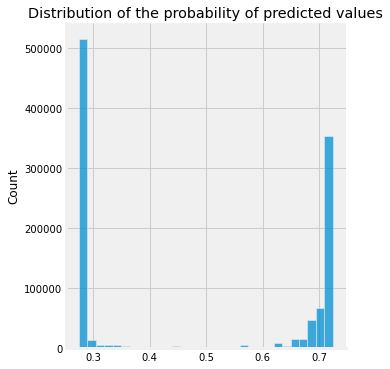

In [20]:
sns.displot(predictionProbabilityArray, bins=30)
plt.title('Distribution of the probability of predicted values')

In [21]:
test_predictions = test_predictions.astype(np.int16)
y_test_int = y_test.astype(np.int16)

In [22]:
print('Test Performance')
print('-------------------------------------------------------')
print(classification_report(y_test, test_predictions))
cm = confusion_matrix(y_test_int, test_predictions)
recall = (cm[0][0] / (cm[0][0] + cm[0][1]))
print('Test Recall')
print('-------------------------------------------------------')
print(recall)
print('Confusion Matrix')
print('-------------------------------------------------------')
print(cm)

Test Performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.96      0.97    580558
           1       0.95      0.98      0.97    514579

    accuracy                           0.97   1095137
   macro avg       0.97      0.97      0.97   1095137
weighted avg       0.97      0.97      0.97   1095137

Test Recall
-------------------------------------------------------
0.9580696502330517
Confusion Matrix
-------------------------------------------------------
[[556215  24343]
 [  9995 504584]]


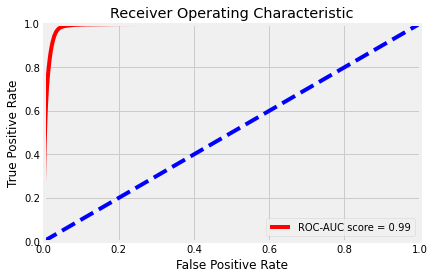

In [23]:
probs = classifier.predict_proba(X_test)
preds = probs[:, 1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'red', label = 'ROC-AUC score = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'b--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Permutation importance

In [24]:
permutation_importance_results = permutation_importance(classifier,
                                                        X=X_test,
                                                        y=y_test,
                                                        n_repeats=10,
                                                        random_state=42)

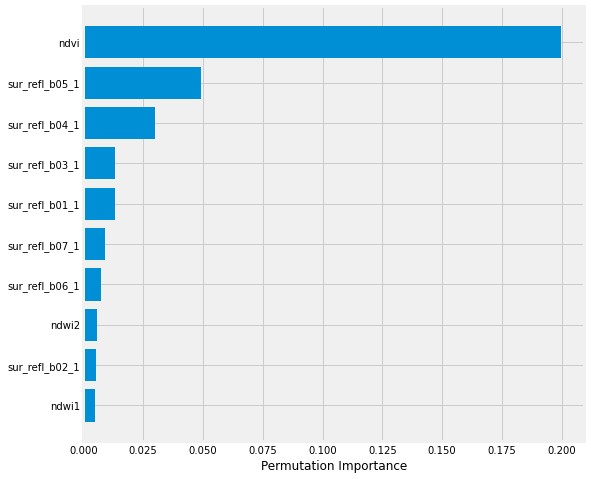

In [26]:
png_save_path = 'mw_{}_{}_{}_{}_permutation_importance.png'.format(
    TILE,
    score,
    MODEL,
    datetime.datetime.now().strftime('%Y_%m_%d_%H_%M'))

png_save_path = os.path.join(FIGURE_OUTPUT_DIR, png_save_path)

sorted_idx = permutation_importance_results.importances_mean.argsort()
plt.figure(figsize=(8, 8))
plt.barh(X_test.columns[sorted_idx], permutation_importance_results.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.savefig(png_save_path)

In [27]:
del X_train, X_test, y_train, y_test, test_predictions, train_predictions, y_test_int

## Save the model for future use

In [29]:
model_sav_path = 'mw_{}_{}_{}_{}_tuned_{}.sav'.format(TILE,
                                                              score,
                                                              MODEL,
                                                              'gpu' if GPU else 'cpu',
                                                              datetime.datetime.now().strftime('%Y_%m_%d_%H_%M'))
model_save_path = os.path.join(MODEL_OUTPUT_DIR, model_sav_path)
print('Saving model to: {}'.format(model_save_path))
print(classifier)
joblib.dump(classifier, model_sav_path, compress=3)

Saving model to: /att/nobackup/cssprad1/projects/modis_water/models/mw_global_0.969_ensemble_gpu_tuned_2022_02_08_20_37.sav
StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(n_estimators=400,
                                                       n_jobs=-1,
                                                       warm_start=True)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None, gamma=None,
                                              gpu_id=None,
                                              importance_type='gain',
                                              interaction_constraints=None,
                                              learning_rate

['mw_global_0.969_ensemble_gpu_tuned_2022_02_08_20_37.sav']

# Testing: Raster testing

In [30]:
TILE = 'h12v09'

In [31]:
DAY = 218
YEAR = 2006
PATH = '/att/nobackup/cssprad1/projects/modis_water/data/test_data/{}/'.format(TILE)

In [32]:
vars_list = [fn for fn in glob.glob(os.path.join(PATH, '*A{}{:03}*.tif'.format(YEAR, DAY)))
            if 'sur_refl' in fn]
vars_list.sort()
vars_list

['/att/nobackup/cssprad1/projects/modis_water/data/test_data/h12v09/MOD09GA.A2006218.h12v09.061.2020268185436-sur_refl_b01_1.tif',
 '/att/nobackup/cssprad1/projects/modis_water/data/test_data/h12v09/MOD09GA.A2006218.h12v09.061.2020268185436-sur_refl_b02_1.tif',
 '/att/nobackup/cssprad1/projects/modis_water/data/test_data/h12v09/MOD09GA.A2006218.h12v09.061.2020268185436-sur_refl_b03_1.tif',
 '/att/nobackup/cssprad1/projects/modis_water/data/test_data/h12v09/MOD09GA.A2006218.h12v09.061.2020268185436-sur_refl_b04_1.tif',
 '/att/nobackup/cssprad1/projects/modis_water/data/test_data/h12v09/MOD09GA.A2006218.h12v09.061.2020268185436-sur_refl_b05_1.tif',
 '/att/nobackup/cssprad1/projects/modis_water/data/test_data/h12v09/MOD09GA.A2006218.h12v09.061.2020268185436-sur_refl_b06_1.tif',
 '/att/nobackup/cssprad1/projects/modis_water/data/test_data/h12v09/MOD09GA.A2006218.h12v09.061.2020268185436-sur_refl_b07_1.tif']

## Get dimensions of inputs

In [33]:
vrt_opts = gdal.BuildVRTOptions(separate=True)
dd = gdal.BuildVRT('tmp.vrt', vars_list, options=vrt_opts)
nrows, ncols = dd.RasterYSize, dd.RasterXSize
dd = None
if os.path.exists('tmp.vrt'):
    os.remove('tmp.vrt') 
nrows, ncols

(4800, 4800)

### Read in data 
We don't need to slice because we have more than enough GPU memory.

In [34]:
def readRasterToArray(vars_list):
    vrt_options = gdal.BuildVRTOptions(separate=True)
    dd = gdal.BuildVRT('tmp.vrt', vars_list, options=vrt_options)
    nrows, ncols = dd.RasterYSize, dd.RasterXSize
    newshp = (ncols*nrows, dd.RasterCount+3)
    img = np.empty(newshp, dtype=np.int16)
    for b in range(len(vars_list)):
        img[:, b] = dd.GetRasterBand(b+1).ReadAsArray().astype(np.int16).ravel()
    dd = None
    img[:, len(vars_list)] = ((img[:, 1] - img[:, 0]) / (img[:, 1] + img[:, 0])) * 10000
    img[:, len(vars_list)+1] = ((img[:, 1] - img[:, 5]) / (img[:, 1] + img[:, 5])) * 10000
    img[:, len(vars_list)+2] = ((img[:, 1] - img[:, 6]) / (img[:, 1] + img[:, 6])) * 10000
    if os.path.exists('tmp.vrt'):
        os.remove('tmp.vrt')
    return img

In [35]:
im = readRasterToArray(vars_list)
print('Raster as ndarray')
print(im)
print('{} MB size'.format((im.size * im.itemsize) / 1000000))

Raster as ndarray
[[6643 7273 6168 ...  452  962 3003]
 [6643 7273 6168 ...  452  962 3003]
 [6172 6885 5686 ...  546  881 2691]
 ...
 [ 419 2432  206 ... 7060 1580 5026]
 [ 751 2327  316 ... 5120 -404 2895]
 [ 751 2327  316 ... 5120 -404 2895]]
460.8 MB size


In [36]:
def predictRaster(img_chunk):
    """
    Function given a raster in the form of a nxn matrix, will
    convert the matrix to a GPU/CPU-bound data frame then perform 
    predictions given the loaded model.
    
    Return the prediction matrix, the prediction probabilities
    for each and the dataframe converted to host.
    """
    df = pd.DataFrame(img_chunk, dtype=np.int16)
    print('Making predictions from raster')
    predictions = classifier.predict(df).astype(np.int16)
    predictionsProbs = classifier.predict_proba(df).astype(np.float32)
    return predictions, predictionsProbs, df

In [37]:
predictedRaster, predictedProbaRaster, df = predictRaster(im)

Making predictions from raster


In [38]:
shp = (4800, 4800)
left = list()
right = list()
for i, subarr in enumerate(predictedProbaRaster):
    left.append(subarr[0])
    right.append(subarr[1])
leftArr = np.asarray(left)
rightArr = np.asarray(right)
probaLand = leftArr.reshape(shp)
probaWater = rightArr.reshape(shp)

## Inputreshapet raster: description and histogram

In [39]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
0,23040000.0,406.319013,434.922643,-28672.0,250.0,306.0,360.0,9953.0
1,23040000.0,3162.238815,649.746304,-28672.0,2923.0,3309.0,3518.0,9242.0
2,23040000.0,291.899561,406.622174,-28672.0,166.0,212.0,269.0,9013.0
3,23040000.0,557.999866,406.551242,-28672.0,421.0,493.0,546.0,9716.0
4,23040000.0,3133.262860,632.134972,-28672.0,2923.0,3264.0,3468.0,9040.0
5,23040000.0,1720.846256,526.672817,-28672.0,1506.0,1710.0,1812.0,7103.0
6,23040000.0,530.845410,1843.350129,-28672.0,480.0,547.0,610.0,6316.0
7,23040000.0,7686.235761,2031.676702,-32222.0,7954.0,8349.0,8546.0,32203.0
8,23040000.0,2985.519139,1161.269606,-32727.0,2979.0,3300.0,3518.0,32620.0
9,23040000.0,6634.247958,1770.533043,-32727.0,6823.0,7209.0,7398.0,32679.0


Text(0.5, 1.0, 'Distribution of each band and calculated idx')

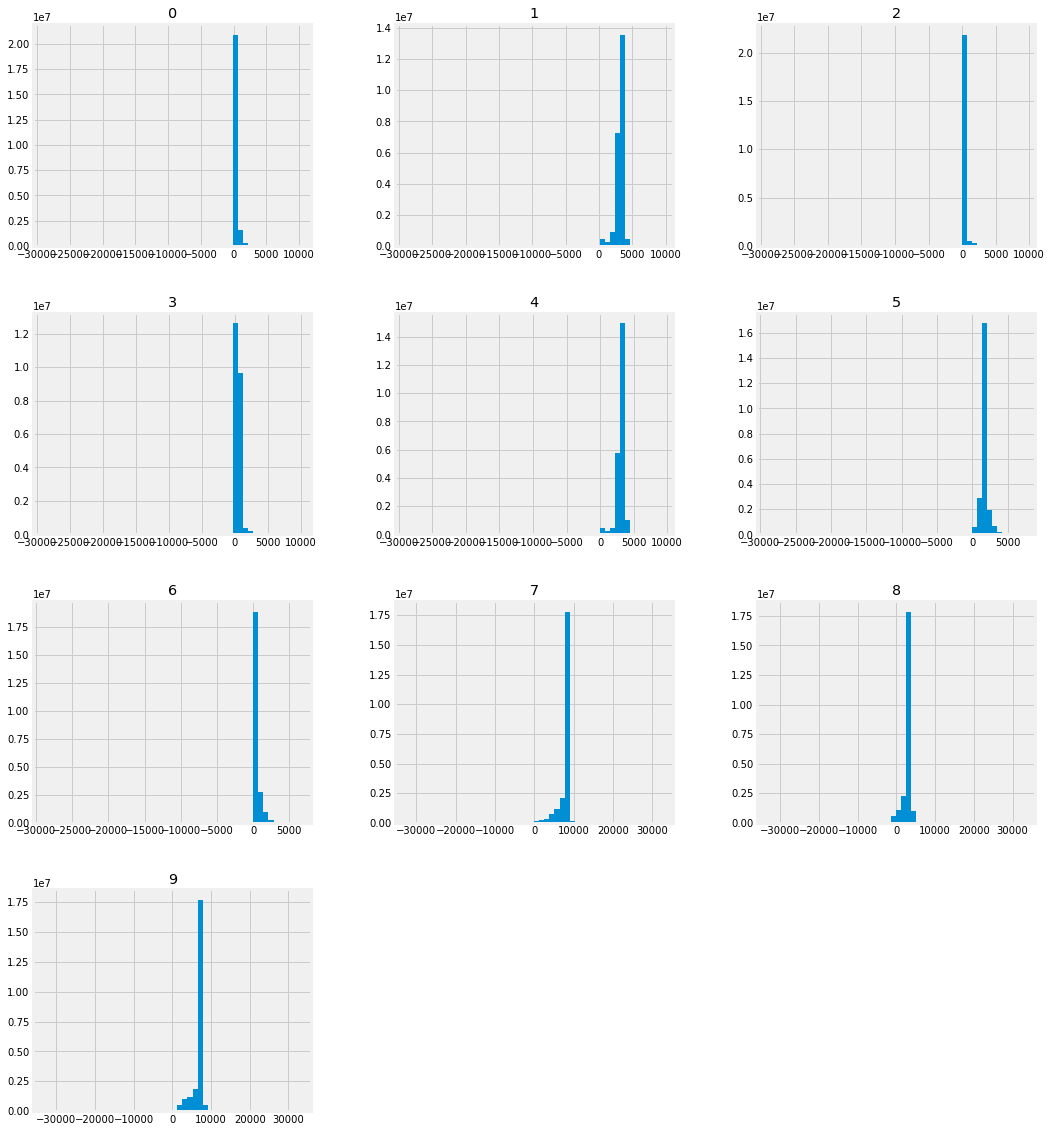

In [40]:
df.hist(figsize=(16, 20), bins=50)
plt.title('Distribution of each band and calculated idx')

#### Reshape the unravelled matrix back to the 4800x4800 raster shape

In [41]:
matrix = np.asarray(predictedRaster)
reshp = matrix.reshape(shp)
reshp.shape

(4800, 4800)

### Import the QA Mask and the Water Mask for the h09v05 TILE

In [42]:
qaMask = '/att/nobackup/cssprad1/projects/modis_water/data/qa_masks'
waterMask = '/att/nobackup/cssprad1/projects/modis_water/data/water_masks/Min2000_2019'
qa_list = [fn for fn in glob.glob(os.path.join(qaMask, '*A{}{:03}.{}*bad_good_mask.tif'.format(YEAR, DAY, TILE)))]
water_list = [fn for fn in glob.glob(os.path.join(waterMask, '*{}*.tif'.format(TILE)))]
qa_mask = qa_list[0]
water_mask = water_list[0]
print(water_mask)
print(qa_mask)
ds = gdal.Open(qa_mask, gdal.GA_ReadOnly)
waterMask = gdal.Open(water_mask, gdal.GA_ReadOnly)
qaMaskMatrix = ds.GetRasterBand(1).ReadAsArray().astype(np.int16)
waterMaskMatrix = waterMask.GetRasterBand(1).ReadAsArray().astype(np.int16)
ds = None
waterMask = None

/att/nobackup/cssprad1/projects/modis_water/data/water_masks/Min2000_2019/MOD44W_h12v09_min2000_2019.tif
/att/nobackup/cssprad1/projects/modis_water/data/qa_masks/MOD09GA.A2006218.h12v09.061.2020268185436_bad_good_mask.tif


In [43]:
waterMaskMatrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

### Mask out results if QA Mask says pixel is "bad"
Mask out water mask if QA Mask says pixel is "bad"

In [44]:
maskedResult = np.where(qaMaskMatrix == 0, reshp, -9999)
maskedResultProba = np.where(qaMaskMatrix == 0, probaWater, -9999)
waterMasked = np.where(qaMaskMatrix == 0, waterMaskMatrix, -9999)
waterMaskRavel = waterMasked.ravel()
imWater = (waterMaskRavel == 1)

# Generating stats for predicted and truth

## Predicted Raster

In [45]:
TILE = 'global_{}_{}'.format(MODEL, TILE)

Text(0.5, 1.0, 'Predicted water mask')

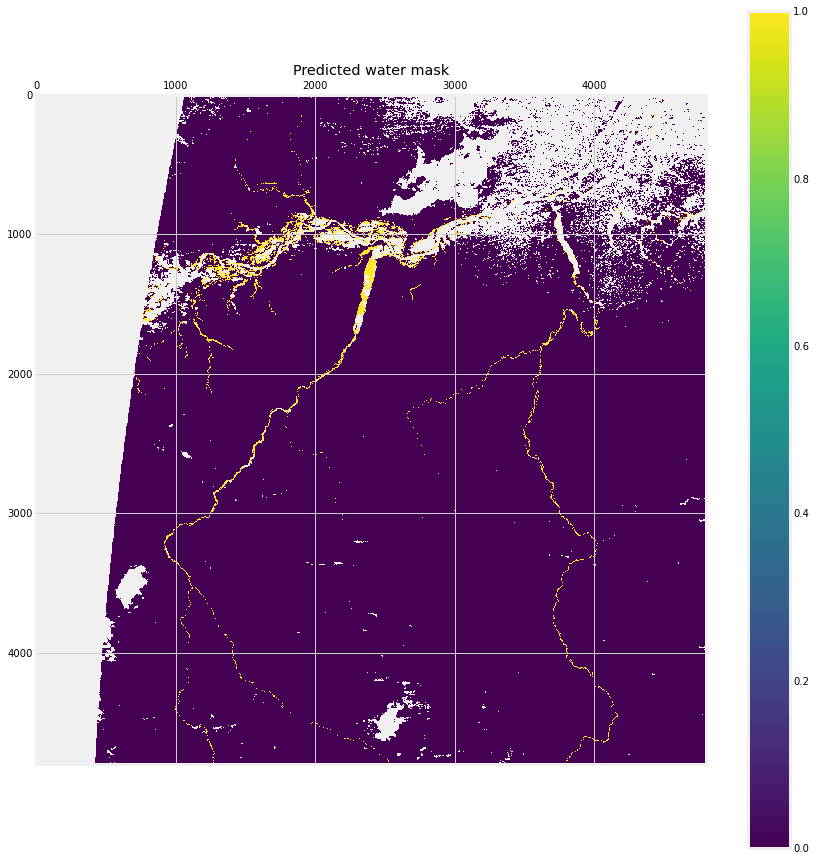

In [46]:
plt.figure(figsize=(15, 15))
outputPlt = plt.matshow(np.where(maskedResult == -9999, np.NaN, maskedResult), fignum=1)
plt.colorbar()
plt.title('Predicted water mask')

## Predicted Probabilities

Text(0.5, 1.0, 'Predicted probabilities of water')

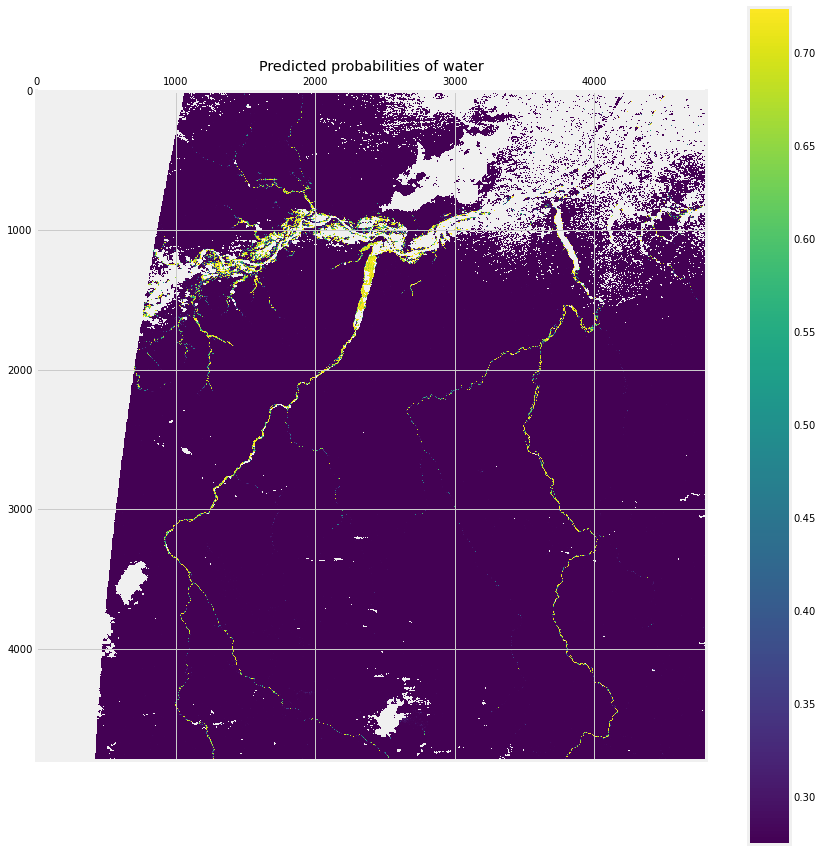

In [47]:
plt.figure(figsize=(15, 15))
outputPlt = plt.matshow(np.where(maskedResult == -9999, np.NaN, maskedResultProba), fignum=1)
plt.colorbar()
plt.title('Predicted probabilities of water')

## Minimum extent water mask

Text(0.5, 1.0, 'Minimum extent water mask')

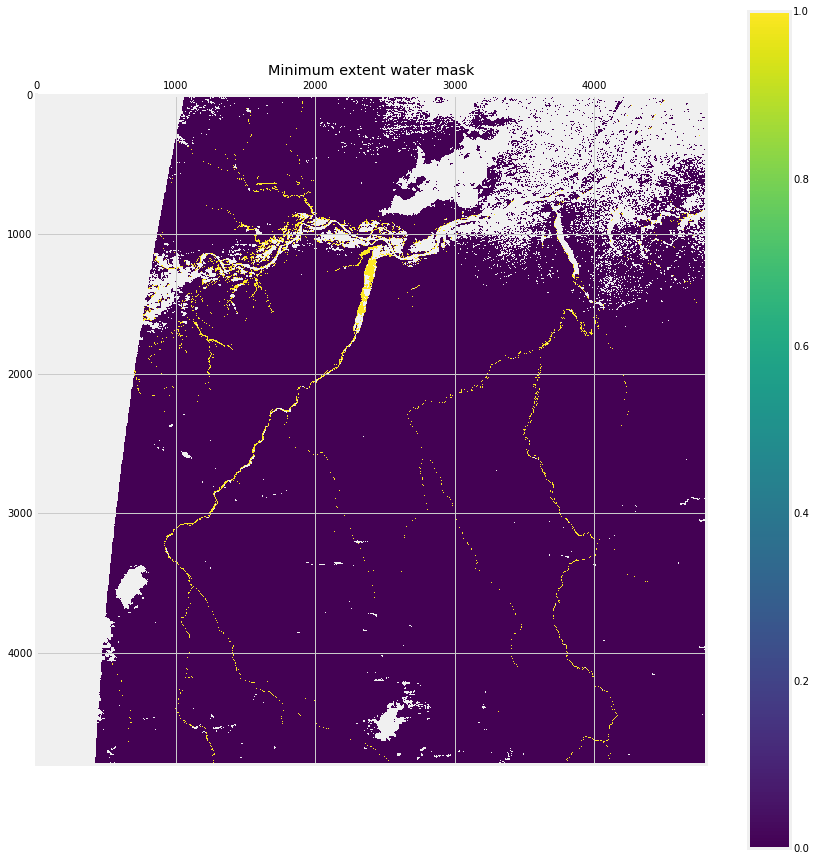

In [48]:
plt.figure(figsize=(15, 15))
truth = np.where(waterMasked==-9999, np.NaN, waterMasked)
truth = np.where(waterMasked==250, np.NaN, truth)
truthPlt = plt.matshow(truth, fignum=1)
plt.colorbar()
plt.title('Minimum extent water mask')

## Metrics on test raster

In [49]:
tp = np.where((waterMasked == 1) & (maskedResult == 1), 1, 0)
tn = np.where((waterMasked == 0) & (maskedResult == 0), 1, 0)
fp = np.where((waterMasked == 0) & (maskedResult == 1), 1, 0)
fn = np.where((waterMasked == 1) & (maskedResult == 0), 1, 0)
total = np.count_nonzero(waterMasked == 1) + np.count_nonzero(waterMasked == 0)
truePositives = np.count_nonzero(tp == 1)
trueNegatives = np.count_nonzero(tn == 1)
falsePositives = np.count_nonzero(fp == 1)
falseNegatives = np.count_nonzero(fn == 1)
accuracy = (truePositives + trueNegatives) / (truePositives + trueNegatives + falsePositives + falseNegatives)
jians = truePositives / (truePositives + trueNegatives)
pc = truePositives / (truePositives + falsePositives)
rc = truePositives / (truePositives + falseNegatives)
f1 = truePositives / (truePositives + (0.5*(falsePositives + falseNegatives)))

### Count num of occurences for each class with the masked predicted result

In [50]:
countNoData = np.count_nonzero(maskedResult == -9999)
countLand = np.count_nonzero(maskedResult == 0)
countWater = np.count_nonzero(maskedResult == 1)
print('Predicted\n Nodata occurences: {}\n Land occurance: {}\n Water occurances: {}'.format(countNoData, countLand, countWater))

Predicted
 Nodata occurences: 5364592
 Land occurance: 17420348
 Water occurances: 255060


### Count num of occurences for each class with the water mask

In [51]:
countNoDataT = np.count_nonzero(waterMasked == -9999)
countLandT = np.count_nonzero(waterMasked == 0)
countWaterT = np.count_nonzero(waterMasked == 1)
print('Truth Vals\n Nodata occurences: {}\n Land occurance: {}\n Water occurances: {}'.format(countNoDataT, countLandT, countWaterT))

Truth Vals
 Nodata occurences: 5364592
 Land occurance: 17468360
 Water occurances: 207048


### Model metrics on raster data

In [52]:
print('Metrics of Accuracy for Raster Test Data')
print('True Positives:  {}'.format(truePositives))
print('True Negatives:  {}'.format(trueNegatives))
print('False Positives: {}'.format(falsePositives))
print('False Negatives: {}'.format(falseNegatives))
print('Total "good" data: {}'.format(total))
print('Accuracy*: {}'.format(accuracy))
print('Precision: {}'.format(pc))
print('Recall: {}'.format(rc))
print('f1: {}'.format(f1))

Metrics of Accuracy for Raster Test Data
True Positives:  158999
True Negatives:  17372299
False Positives: 96061
False Negatives: 48049
Total "good" data: 17675408
Accuracy*: 0.9918468642986912
Precision: 0.6233788128283542
Recall: 0.7679330396816197
f1: 0.6881464938932025


## Output predicted raster to GeoTiff

In [53]:
outPath = os.path.join(RASTER_OUTPUT_DIR, '{}_{}_{}_predicted_{}.tif'.format(YEAR, DAY, TILE, MODEL))
waterMaskForDay = os.path.join(RASTER_OUTPUT_DIR, 'waterMask_{}_qa_{}.tif'.format(YEAR, DAY, TILE, MODEL))
outPathProba = os.path.join(RASTER_OUTPUT_DIR, '{}_{}_{}_predicted_probabilities_{}.tif'.format(YEAR, DAY, TILE, MODEL))
print(outPath)
print(waterMaskForDay)
print(outPathProba)

ds = gdal.Open(vars_list[0], gdal.GA_ReadOnly)
geo = ds.GetGeoTransform()
proj = ds.GetProjection()
ncols = ds.RasterXSize
nrows = ds.RasterYSize
print('Transform')
print(geo)
print('Projection')
print(proj)
print('Width')
print(ncols)
print('Height')
print(nrows)
ds = None

# Output predicted binary raster masked with good-bad mask.
driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(outPath, ncols, nrows, 1, gdal.GDT_Float32, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geo)
outDs.SetProjection(proj)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(maskedResult)
outBand.SetNoDataValue(-9999)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

# Output water mask with good-bad masked.
driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(waterMaskForDay, ncols, nrows, 1, gdal.GDT_Int16, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geo)
outDs.SetProjection(proj)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(waterMasked)
outBand.SetNoDataValue(-9999)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

# Output probabilies raster masked by good-bad mask.
driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(outPathProba, ncols, nrows, 1, gdal.GDT_Float32, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geo)
outDs.SetProjection(proj)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(maskedResultProba)
outBand.SetNoDataValue(-9999)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

/att/nobackup/cssprad1/projects/modis_water/code/modis_water_random_forest/view/notebook/output/2006_218_global_ensemble_h12v09_predicted_ensemble.tif
/att/nobackup/cssprad1/projects/modis_water/code/modis_water_random_forest/view/notebook/output/waterMask_2006_qa_218.tif
/att/nobackup/cssprad1/projects/modis_water/code/modis_water_random_forest/view/notebook/output/2006_218_global_ensemble_h12v09_predicted_probabilities_ensemble.tif
Transform
(-6671703.118, 231.656358, 0.0, 0.0, 0.0, -231.656358)
Projection
PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid",DATUM["Not_specified_based_on_custom_spheroid",SPHEROID["Custom spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Width
4800
Height
4800
